# Correction : Prédiction de notation de restaurants

## 1. Génération du dataset

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [20]:
np.random.seed(42)
n_restaurants = 1000

data = {
    'price_range': np.random.choice([1, 2, 3, 4], n_restaurants, p=[0.2, 0.35, 0.3, 0.15]),
    'cuisine_type': np.random.choice(['Italien', 'Français', 'Japonais', 'Mexicain',
                                       'Indien', 'Américain', 'Chinois', 'Méditerranéen'], n_restaurants),
    'city_zone': np.random.choice(['Centre', 'Banlieue', 'Périphérie'], n_restaurants, p=[0.4, 0.35, 0.25]),
    'seating_capacity': np.random.randint(20, 200, n_restaurants),
    'years_open': np.random.randint(1, 30, n_restaurants),
    'has_terrace': np.random.choice([0, 1], n_restaurants, p=[0.6, 0.4]),
    'has_parking': np.random.choice([0, 1], n_restaurants, p=[0.5, 0.5]),
    'delivery_service': np.random.choice([0, 1], n_restaurants, p=[0.4, 0.6]),
    'accepts_reservation': np.random.choice([0, 1], n_restaurants, p=[0.3, 0.7]),
    'vegetarian_options': np.random.choice([0, 1], n_restaurants, p=[0.2, 0.8]),
    'avg_wait_time': np.random.randint(5, 60, n_restaurants),
    'chef_experience': np.random.randint(0, 25, n_restaurants)
}

restaurants = pd.DataFrame(data)

score = (
    restaurants['price_range'] * 15 +
    restaurants['chef_experience'] * 2 +
    restaurants['years_open'] * 1.5 +
    (restaurants['city_zone'] == 'Centre') * 20 +
    restaurants['has_terrace'] * 10 +
    restaurants['has_parking'] * 8 +
    restaurants['accepts_reservation'] * 12 +
    restaurants['vegetarian_options'] * 5 +
    (60 - restaurants['avg_wait_time']) * 0.5 +
    np.random.normal(0, 15, n_restaurants)
)

restaurants['rating_category'] = pd.cut(
    score,
    bins=4,
    labels=['Moyen', 'Bon', 'Très bon', 'Excellent']
)

print(restaurants.head(10))
print(f"\nDistribution des catégories :\n{restaurants['rating_category'].value_counts().sort_index()}")

   price_range   cuisine_type   city_zone  seating_capacity  years_open  \
0            2        Chinois    Banlieue               198          14   
1            4       Mexicain    Banlieue               194          10   
2            3      Américain      Centre                23          17   
3            3  Méditerranéen      Centre               154          10   
4            1  Méditerranéen      Centre               128          26   
5            1       Japonais      Centre               182           7   
6            1  Méditerranéen    Banlieue                67          16   
7            4        Chinois    Banlieue                92           1   
8            3         Indien    Banlieue                91          17   
9            3        Italien  Périphérie               135          21   

   has_terrace  has_parking  delivery_service  accepts_reservation  \
0            0            0                 0                    1   
1            0            1       

## 2. Exploration des données

In [21]:
print(f"Valeurs manquantes :\n{restaurants.isnull().sum()}")

Valeurs manquantes :
price_range            0
cuisine_type           0
city_zone              0
seating_capacity       0
years_open             0
has_terrace            0
has_parking            0
delivery_service       0
accepts_reservation    0
vegetarian_options     0
avg_wait_time          0
chef_experience        0
rating_category        0
dtype: int64


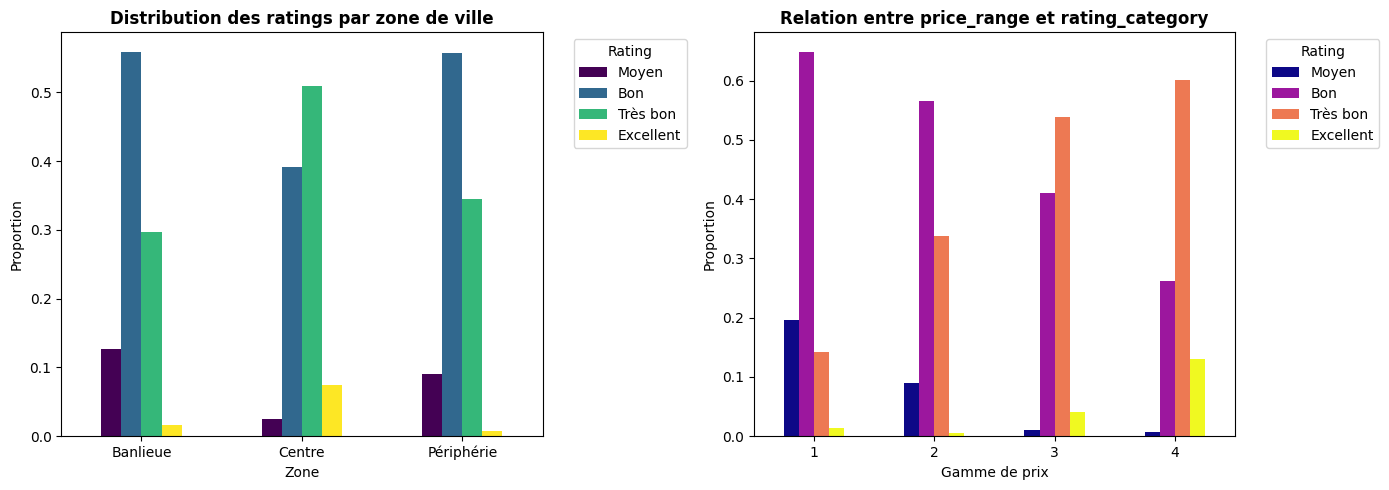

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

zone_rating = pd.crosstab(restaurants['city_zone'], restaurants['rating_category'], normalize='index')
zone_rating.plot(kind='bar', ax=axes[0], colormap='viridis')
axes[0].set_title('Distribution des ratings par zone de ville', fontweight='bold')
axes[0].set_xlabel('Zone')
axes[0].set_ylabel('Proportion')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend(title='Rating', bbox_to_anchor=(1.05, 1))

price_rating = pd.crosstab(restaurants['price_range'], restaurants['rating_category'], normalize='index')
price_rating.plot(kind='bar', ax=axes[1], colormap='plasma')
axes[1].set_title('Relation entre price_range et rating_category', fontweight='bold')
axes[1].set_xlabel('Gamme de prix')
axes[1].set_ylabel('Proportion')
axes[1].tick_params(axis='x', rotation=0)
axes[1].legend(title='Rating', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

## 3. Préparation des données

In [23]:
cat_cols = ['cuisine_type', 'city_zone']
num_cols = [c for c in restaurants.columns if c not in cat_cols + ['rating_category']]

preprocessor = ColumnTransformer(transformers=[
    ('encoder', OrdinalEncoder(), cat_cols),
    ('scaler', StandardScaler(), num_cols)
])

X = restaurants.drop(columns=['rating_category'])
y = restaurants['rating_category'].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train : {X_train.shape[0]} restaurants | Test : {X_test.shape[0]} restaurants")

Train : 800 restaurants | Test : 200 restaurants


## 4. Construction et évaluation des modèles

In [24]:
models = {
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('clf', KNeighborsClassifier(n_neighbors=5))
    ]),
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('clf', DecisionTreeClassifier(random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
}

results = []
predictions = {}

for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    predictions[name] = y_pred

    results.append({
        'Modele': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    })
    print(f"{name}: Accuracy={accuracy_score(y_test, y_pred):.3f} | F1={f1_score(y_test, y_pred, average='weighted', zero_division=0):.3f}")

KNN: Accuracy=0.600 | F1=0.576
Decision Tree: Accuracy=0.580 | F1=0.585
Random Forest: Accuracy=0.685 | F1=0.654


## 5. Tableau comparatif

In [25]:
results_sorted = sorted(results, key=lambda x: x['F1-Score'], reverse=True)

print(f"{'Modele':<18} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1-Score':>10}")
for r in results_sorted:
    print(f"{r['Modele']:<18} {r['Accuracy']:>10.3f} {r['Precision']:>10.3f} {r['Recall']:>10.3f} {r['F1-Score']:>10.3f}")

Modele               Accuracy  Precision     Recall   F1-Score
Random Forest           0.685      0.688      0.685      0.654
Decision Tree           0.580      0.593      0.580      0.585
KNN                     0.600      0.563      0.600      0.576


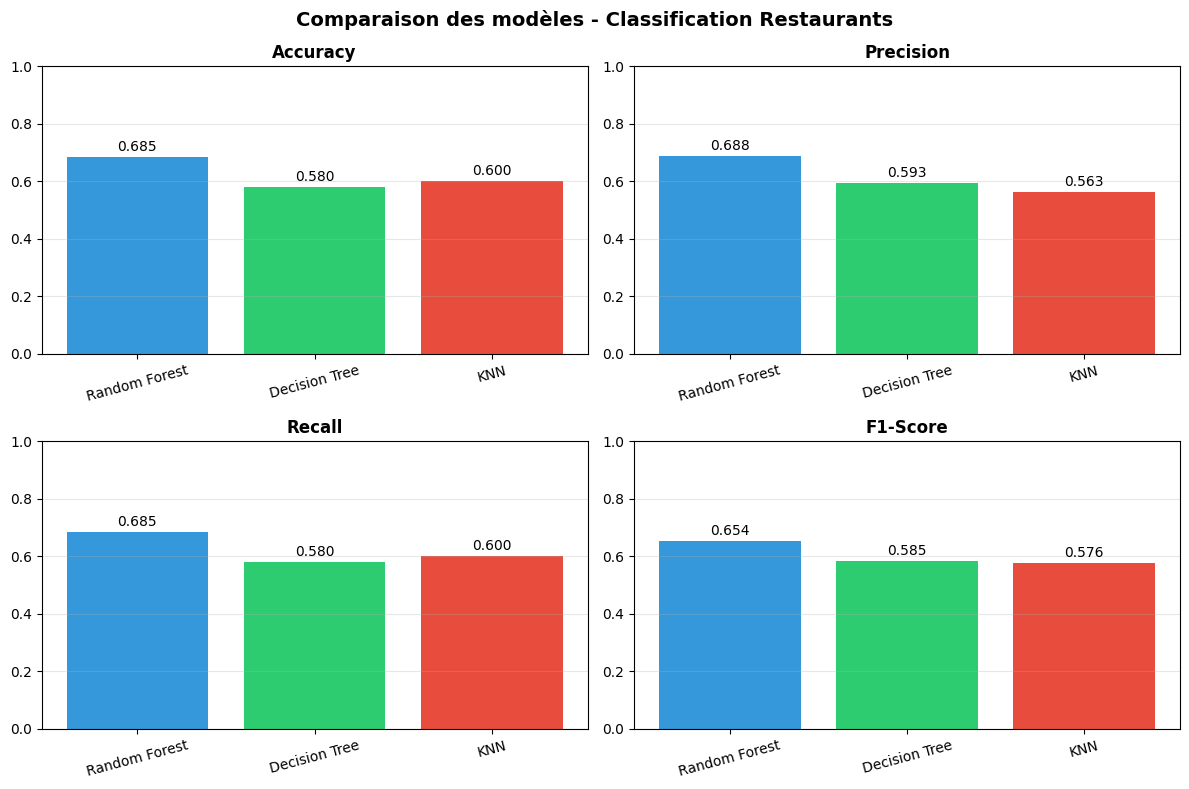

In [26]:
model_names = [r['Modele'] for r in results_sorted]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
colors = ['#3498db', '#2ecc71', '#e74c3c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = [r[metric] for r in results_sorted]
    bars = ax.bar(model_names, values, color=colors[:len(model_names)])
    ax.set_title(metric, fontweight='bold', fontsize=12)
    ax.set_ylim([0.0, 1.0])
    ax.tick_params(axis='x', rotation=15)
    ax.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Comparaison des modèles - Classification Restaurants', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Prédiction sur de nouveaux restaurants

In [ ]:
nouveaux_restaurants = pd.DataFrame({
    'price_range':         [4,   1,   3],
    'cuisine_type':        ['Français',    'Américain', 'Japonais'],
    'city_zone':           ['Centre',      'Périphérie', 'Banlieue'],
    'seating_capacity':    [50,  120,  80],
    'years_open':          [20,   2,   8],
    'has_terrace':         [1,    0,   1],
    'has_parking':         [1,    1,   0],
    'delivery_service':    [0,    1,   1],
    'accepts_reservation': [1,    0,   1],
    'vegetarian_options':  [1,    0,   1],
    'avg_wait_time':       [15,  40,  25],
    'chef_experience':     [20,   2,  12]
})

noms = ['Restaurant Gastronomique', 'Fast Food Périphérie', 'Brasserie Moderne']
best_model = models[results_sorted[0]['Modele']]

predictions_nouveaux = best_model.predict(nouveaux_restaurants)

print(f"Modèle utilisé : {results_sorted[0]['Modele']}\n")
for nom, pred in zip(noms, predictions_nouveaux):
    print(f"  {nom:<30} -> {pred}")

Modèle utilisé : Random Forest

  Restaurant Gastronomique       -> Excellent
  Fast Food Périphérie           -> Moyen
  Brasserie Moderne              -> Très bon
